<font size="5"><center> **Exercise 1.b <br>
(WGAN with Wasserstein loss function on Fashion MNIST dataset.)** </center></font>
<font size="4"><center> CS-673 <br> Introduction to Deep Generative Models </center></font>
<font size="4"><center> Sifakis Emmanouil, *1288* </center></font>

---

↓ Imports ↓

In [5]:
# # Comment the following lines if you're not in colab:
# from google.colab import drive
# drive.mount('/content/drive')
# # If you're in colab, cd to your own working directory here:
# %cd ..//..//content//drive//MyDrive//Colab-Notebooks//HY-673-Tutorials//Tutorial-9

In [6]:
import torch as tc
import torch.nn as nn
import torchvision.transforms as transforms
from torch.optim import RMSprop
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

<font size = '3'>The following notebook is based entirely on the WGAN Tutorial 10 of this course. The main changes include using the FashionMNIST dataset instead of MNIST and modifications to the architecture of the Generator and Discriminator as outlined in the previous question (1.a). Additional changes include the implementation of the Wasserstein loss and the different training iterations for the Discriminator versus the Generator.

<font size = '3'> (Same as the `1.a` question)

- Generator Class: generator model with one dense layer followed by three convolutional layers. The generator takes a noise vector (latent space input) and transforms it into a 28x28 image. <br>
- Discriminator Network: discriminator model with three convolutional layers followed by one dense layer. It takes an image as input and outputs a single scalar value representing the probability of the input image being real or fake. 

↓ Generator / Discriminator ↓

In [7]:
class Generator(nn.Module):
    def __init__(self, input_shape=(1, 28, 28), noise_shape=(100,)):
        super().__init__()

        self.noise_shape = noise_shape
        self.noise_dim = np.prod(noise_shape)
        self.data_shape = input_shape

        self.model = nn.Sequential(
            nn.Linear(self.noise_dim, 7*7*128),
            nn.BatchNorm1d(7*7*128),
            nn.PReLU(),
            nn.Unflatten(1, (128, 7, 7)),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.PReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.PReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, noise):
        return self.model(noise.view(-1, self.noise_dim))

class Discriminator(nn.Module):
    def __init__(self, input_shape=(1, 28, 28)):
        super().__init__()

        self.data_shape = input_shape

        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.PReLU(),
            nn.Dropout(0.3),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.PReLU(),
            nn.Dropout(0.3),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.PReLU(),
            nn.Flatten(),
            nn.Linear(128*3*3, 1)
        )

    def forward(self, x):
        return self.model(x.view(-1, *self.data_shape))

<font size = '3'>(Same as `1.a`)

- `Weight Initialization` function for the weights of the model to ensure proper convergence during training.
- `generate` function for generation and display of samples from the generator model.
- `plot_loss` function, that plots the loss curves for both the generator and the discriminator over the epochs.
- `load_and_generate` function that loads a pre-trained generator model from a saved file and generates images. It also plots the loss curves.


In [8]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

def generate(n_samples, title, gen, noise_dim, device):
    z = tc.randn(n_samples, noise_dim, device=device)
    x_hat = gen(z).detach().cpu().numpy()

    n_rows = (n_samples + 3) // 4
    fig, axs = plt.subplots(
        nrows=n_rows,
        ncols=4,
        figsize=(8, 2*n_rows),
        subplot_kw={'xticks': [], 'yticks': [], 'frame_on': False}
    )
    for i, axis in enumerate(axs.flat[:n_samples]):
        axis.imshow(x_hat[i].reshape(28, 28), cmap='binary')
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    fig.suptitle(title, fontsize=16)
    plt.show()
    plt.close()

def plot_loss(d_loss, g_loss, epochs):

    epoch_ax = np.arange(start=1, stop=epochs+1, step=1)
    _, ax = plt.subplots(1, 2, figsize=(15, 5))

    ax[0].plot(epoch_ax, d_loss, color='blue')
    ax[0].set_xlim(1, epochs)
    ax[0].set_title("Discriminator Loss vs Epoch")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Discriminator Loss")
    ax[0].grid(alpha=0.45)

    ax[1].plot(epoch_ax, g_loss, color='red')
    ax[1].set_xlim(1, epochs)
    ax[1].set_title("Generator Loss vs Epoch")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Generator Loss")
    ax[1].grid(alpha=0.45)

    plt.tight_layout()
    plt.show()
    plt.close()

# Function to load the best generator model and generate images
def load_and_generate(filename, n_samples, data_shape, noise_dim, device):
    with open(filename, 'rb') as f:
        data = pickle.load(f)

    epoch = int(data['all_epochs'])    
    best_epoch = int(data['best_epoch'])
    d_loss = data['disc_losses']
    g_loss = data['gen_losses']
    
    title= f"Generated Images for Best Model - Epoch: {best_epoch+1}"
    gen = Generator(input_shape=data_shape, noise_shape=noise_dim).to(device)
    gen.load_state_dict(data['model_state_dict'])
    gen.eval()   
    
    generate(n_samples, title, gen, noise_dim, device)
    plot_loss(d_loss, g_loss, epoch)

The below `training loop` function performs the training loop for the GAN. It trains the discriminator and the generator in alternating steps, applying the WGAN-GP loss function, and saving the best generator model based on the generator loss. It also periodically generates samples during training and saves the model checkpoints.

<font size = '4'> <b>Wasserstein GAN Loss </b> </font>

<font size = '3'>
Wasserstein GAN (WGAN) aims to improve the training stability of GANs by using the Wasserstein distance (Earth-Mover distance) instead of the Jensen-Shannon divergence. The Wasserstein loss for WGAN is defined as follows:

Discriminator (Critic) Loss:<br>

$ L_D = -\mathbb{E}_{\mathbf{x} \sim p_{\text{data}}} [D(\mathbf{x})] + \mathbb{E}_{\mathbf{z} \sim p_{\mathbf{z}}} [D(G(\mathbf{z}))] $

- $\mathbf{x}$ is a real sample from the data distribution \(p_{\text{data}}\).
- $\mathbf{z}$ is a random noise vector sampled from the noise distribution \(p_{\mathbf{z}}\).
- $D(\mathbf{x})$ is the discriminator's (critic's) output for a real sample.
- $G(\mathbf{z})$ is the generator's output for a noise vector.

- Generator Loss:
$ L_G = -\mathbb{E}_{\mathbf{z} \sim p_{\mathbf{z}}} [D(G(\mathbf{z}))] $

- $D(G(\mathbf{z}))$ is the discriminator's (critic's) output for a generated sample.

<font size = '4'> <b>Difference in Training Steps for Discriminator vs Generator</b> </font>

<font size = '3'>
In WGAN, the discriminator (critic) is trained more frequently than the generator to ensure the discriminator provides a good approximation of the Wasserstein distance. This is because the discriminator needs to reach its optimum faster than the generator for better gradient updates. For this reason in this notebook the discriminator is trained `5` times more in relation to hte training of the generator.
<br>

↓ Train Loop ↓

In [9]:
def train_loop(gen, disc, opt_disc, opt_gen, train_loader, noise_dim,
               n_samples, epochs, sample_every, max_amp, d_iterations, check_path, device):
    
    disc_losses = np.zeros(epochs)
    gen_losses = np.zeros(epochs)
    gen.train()
    disc.train()
    
    best_gen_loss = float('inf')
    best_epoch = 0

    for epoch in range(epochs):

        gen_loss = 0
        disc_loss = 0

        for i, (x, _) in enumerate(tqdm(train_loader)):

            # ------------------------ Train Discriminator: ------------------------
            for _ in range(d_iterations):

                opt_disc.zero_grad()
                x = x.to(device)
                z = tc.randn(x.shape[0], noise_dim).to(device)
                x_hat = gen(z)

                loss_disc = -tc.mean(disc(x)) + tc.mean(disc(x_hat))
                disc_loss += loss_disc.item()

                loss_disc.backward()
                opt_disc.step()

                # Clipping discriminator parameters to enforce Lipschitz constraint
                for p in disc.parameters():
                    p.data.clamp_(-max_amp, max_amp)

            # ------------------------ Train Generator: ------------------------
            z = tc.randn(x.shape[0], noise_dim).to(device)
            x_hat = gen(z)
            gen.zero_grad()

            loss_gen = -tc.mean(disc(x_hat))

            loss_gen.backward()
            opt_gen.step()

            gen_loss += loss_gen.item()

        # Print:
        disc_losses[epoch] = disc_loss / len(train_loader)
        gen_losses[epoch] = gen_loss / (len(train_loader) // 5)
        print(f"Epoch [{epoch+1}/{epochs}] | Loss D: {disc_losses[epoch]:.4f} | Loss G: {gen_losses[epoch]:.4f}")
        
        # Save the best generator model
        if gen_losses[epoch] < best_gen_loss:
            best_gen_loss = gen_losses[epoch]
            best_gen_model = gen.state_dict()
            best_epoch = epoch           
        
        # Sample:
        if (epoch + 1) % sample_every == 0:
            gen.eval()
            generate(n_samples, f"Epoch {epoch + 1}", gen, noise_dim, device)
            gen.train()
    
    # Save the best generator model and losses to disk
    save_data = {
        'model_state_dict': best_gen_model,
        'best_epoch': best_epoch,
        'all_epochs': epochs,
        'disc_losses': disc_losses,
        'gen_losses': gen_losses
    }
    with open(check_path, 'wb') as f:
        pickle.dump(save_data, f)

    return disc_losses, gen_losses

Using --> cuda


100%|██████████| 469/469 [00:30<00:00, 15.56it/s]


Epoch [1/100] | Loss D: -0.1149 | Loss G: 0.0684


100%|██████████| 469/469 [00:32<00:00, 14.30it/s]


Epoch [2/100] | Loss D: -0.0787 | Loss G: 0.0401


100%|██████████| 469/469 [00:33<00:00, 13.93it/s]


Epoch [3/100] | Loss D: -0.0557 | Loss G: 0.0267


100%|██████████| 469/469 [00:33<00:00, 13.87it/s]


Epoch [4/100] | Loss D: -0.0443 | Loss G: 0.0130


100%|██████████| 469/469 [00:34<00:00, 13.69it/s]


Epoch [5/100] | Loss D: -0.0370 | Loss G: 0.0083


100%|██████████| 469/469 [00:33<00:00, 13.91it/s]


Epoch [6/100] | Loss D: -0.0319 | Loss G: -0.0003


100%|██████████| 469/469 [00:33<00:00, 13.84it/s]


Epoch [7/100] | Loss D: -0.0284 | Loss G: -0.0010


100%|██████████| 469/469 [00:34<00:00, 13.50it/s]


Epoch [8/100] | Loss D: -0.0255 | Loss G: -0.0041


100%|██████████| 469/469 [00:34<00:00, 13.73it/s]


Epoch [9/100] | Loss D: -0.0235 | Loss G: -0.0076


100%|██████████| 469/469 [00:34<00:00, 13.70it/s]


Epoch [10/100] | Loss D: -0.0212 | Loss G: -0.0104


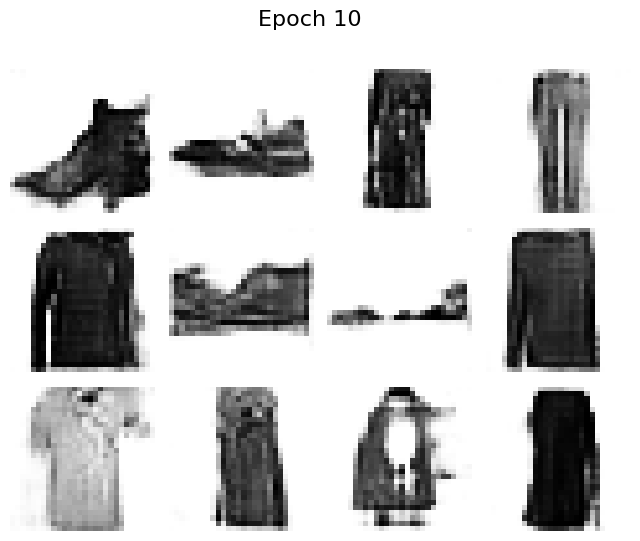

100%|██████████| 469/469 [00:35<00:00, 13.40it/s]


Epoch [11/100] | Loss D: -0.0195 | Loss G: -0.0169


100%|██████████| 469/469 [00:35<00:00, 13.31it/s]


Epoch [12/100] | Loss D: -0.0184 | Loss G: -0.0168


100%|██████████| 469/469 [00:36<00:00, 12.99it/s]


Epoch [13/100] | Loss D: -0.0171 | Loss G: -0.0183


100%|██████████| 469/469 [00:35<00:00, 13.31it/s]


Epoch [14/100] | Loss D: -0.0157 | Loss G: -0.0221


100%|██████████| 469/469 [00:35<00:00, 13.31it/s]


Epoch [15/100] | Loss D: -0.0151 | Loss G: -0.0223


100%|██████████| 469/469 [00:35<00:00, 13.30it/s]


Epoch [16/100] | Loss D: -0.0142 | Loss G: -0.0245


100%|██████████| 469/469 [00:34<00:00, 13.47it/s]


Epoch [17/100] | Loss D: -0.0133 | Loss G: -0.0243


100%|██████████| 469/469 [00:33<00:00, 13.96it/s]


Epoch [18/100] | Loss D: -0.0126 | Loss G: -0.0231


100%|██████████| 469/469 [00:34<00:00, 13.43it/s]


Epoch [19/100] | Loss D: -0.0119 | Loss G: -0.0214


100%|██████████| 469/469 [00:34<00:00, 13.59it/s]


Epoch [20/100] | Loss D: -0.0100 | Loss G: -0.0271


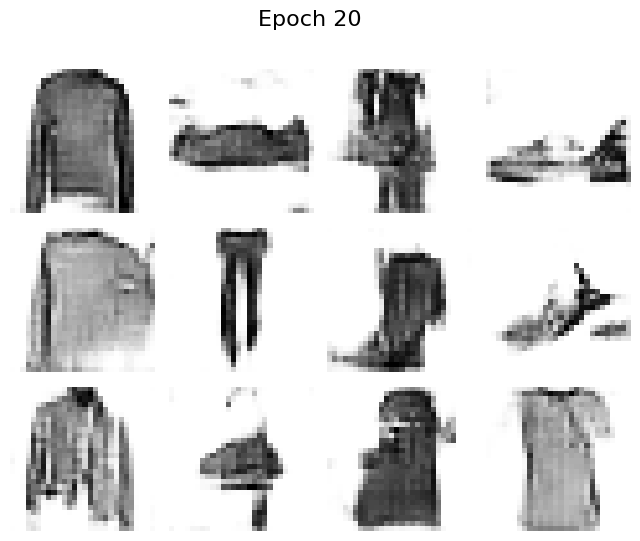

100%|██████████| 469/469 [00:34<00:00, 13.48it/s]


Epoch [21/100] | Loss D: -0.0054 | Loss G: -0.0408


100%|██████████| 469/469 [00:34<00:00, 13.54it/s]


Epoch [22/100] | Loss D: -0.0027 | Loss G: -0.0738


100%|██████████| 469/469 [00:32<00:00, 14.32it/s]


Epoch [23/100] | Loss D: -0.0023 | Loss G: -0.0290


100%|██████████| 469/469 [00:35<00:00, 13.18it/s]


Epoch [24/100] | Loss D: -0.0033 | Loss G: -0.0234


100%|██████████| 469/469 [00:35<00:00, 13.37it/s]


Epoch [25/100] | Loss D: -0.0032 | Loss G: -0.0157


100%|██████████| 469/469 [00:34<00:00, 13.46it/s]


Epoch [26/100] | Loss D: -0.0040 | Loss G: 0.0047


100%|██████████| 469/469 [00:34<00:00, 13.49it/s]


Epoch [27/100] | Loss D: -0.0035 | Loss G: -0.0679


100%|██████████| 469/469 [00:34<00:00, 13.77it/s]


Epoch [28/100] | Loss D: -0.0042 | Loss G: -0.0546


100%|██████████| 469/469 [00:36<00:00, 13.02it/s]


Epoch [29/100] | Loss D: -0.0046 | Loss G: -0.0527


100%|██████████| 469/469 [00:34<00:00, 13.67it/s]


Epoch [30/100] | Loss D: -0.0069 | Loss G: -0.0205


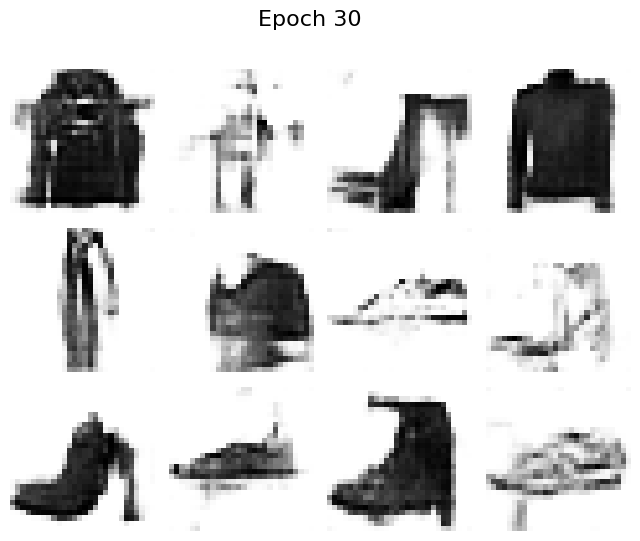

100%|██████████| 469/469 [00:34<00:00, 13.64it/s]


Epoch [31/100] | Loss D: -0.0075 | Loss G: -0.0282


100%|██████████| 469/469 [00:35<00:00, 13.34it/s]


Epoch [32/100] | Loss D: -0.0145 | Loss G: -0.0188


100%|██████████| 469/469 [00:35<00:00, 13.31it/s]


Epoch [33/100] | Loss D: -0.0191 | Loss G: -0.0273


100%|██████████| 469/469 [00:30<00:00, 15.40it/s]


Epoch [34/100] | Loss D: -0.0200 | Loss G: -0.0325


100%|██████████| 469/469 [00:29<00:00, 15.81it/s]


Epoch [35/100] | Loss D: -0.0188 | Loss G: -0.0330


100%|██████████| 469/469 [00:33<00:00, 13.93it/s]


Epoch [36/100] | Loss D: -0.0152 | Loss G: -0.0426


100%|██████████| 469/469 [00:38<00:00, 12.26it/s]


Epoch [37/100] | Loss D: -0.0061 | Loss G: -0.0419


100%|██████████| 469/469 [00:38<00:00, 12.33it/s]


Epoch [38/100] | Loss D: -0.0043 | Loss G: -0.0375


100%|██████████| 469/469 [00:38<00:00, 12.17it/s]


Epoch [39/100] | Loss D: -0.0039 | Loss G: -0.0379


100%|██████████| 469/469 [00:37<00:00, 12.49it/s]


Epoch [40/100] | Loss D: -0.0036 | Loss G: -0.0698


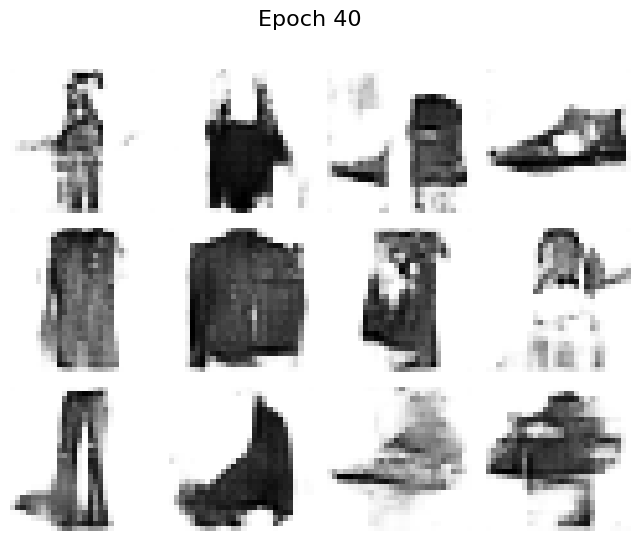

100%|██████████| 469/469 [00:37<00:00, 12.62it/s]


Epoch [41/100] | Loss D: -0.0040 | Loss G: -0.0312


100%|██████████| 469/469 [00:37<00:00, 12.49it/s]


Epoch [42/100] | Loss D: -0.0033 | Loss G: -0.0749


100%|██████████| 469/469 [00:38<00:00, 12.20it/s]


Epoch [43/100] | Loss D: -0.0041 | Loss G: -0.0516


100%|██████████| 469/469 [00:40<00:00, 11.64it/s]


Epoch [44/100] | Loss D: -0.0040 | Loss G: -0.0375


100%|██████████| 469/469 [00:43<00:00, 10.85it/s]


Epoch [45/100] | Loss D: -0.0044 | Loss G: -0.0410


100%|██████████| 469/469 [00:40<00:00, 11.67it/s]


Epoch [46/100] | Loss D: -0.0041 | Loss G: -0.0190


100%|██████████| 469/469 [00:38<00:00, 12.23it/s]


Epoch [47/100] | Loss D: -0.0079 | Loss G: -0.0046


100%|██████████| 469/469 [00:38<00:00, 12.33it/s]


Epoch [48/100] | Loss D: -0.0159 | Loss G: -0.0231


100%|██████████| 469/469 [00:38<00:00, 12.23it/s]


Epoch [49/100] | Loss D: -0.0170 | Loss G: -0.0261


100%|██████████| 469/469 [00:41<00:00, 11.38it/s]


Epoch [50/100] | Loss D: -0.0165 | Loss G: -0.0239


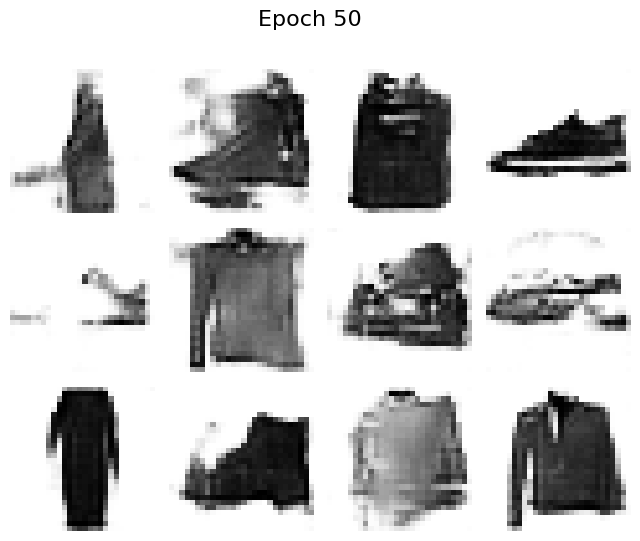

100%|██████████| 469/469 [00:30<00:00, 15.31it/s]


Epoch [51/100] | Loss D: -0.0154 | Loss G: -0.0228


100%|██████████| 469/469 [00:28<00:00, 16.56it/s]


Epoch [52/100] | Loss D: -0.0137 | Loss G: -0.0319


100%|██████████| 469/469 [00:28<00:00, 16.50it/s]


Epoch [53/100] | Loss D: -0.0087 | Loss G: -0.0418


100%|██████████| 469/469 [00:28<00:00, 16.52it/s]


Epoch [54/100] | Loss D: -0.0044 | Loss G: -0.0200


100%|██████████| 469/469 [00:28<00:00, 16.53it/s]


Epoch [55/100] | Loss D: -0.0031 | Loss G: -0.0555


100%|██████████| 469/469 [00:28<00:00, 16.48it/s]


Epoch [56/100] | Loss D: -0.0032 | Loss G: -0.0594


100%|██████████| 469/469 [00:28<00:00, 16.53it/s]


Epoch [57/100] | Loss D: -0.0040 | Loss G: -0.0750


100%|██████████| 469/469 [00:28<00:00, 16.50it/s]


Epoch [58/100] | Loss D: -0.0049 | Loss G: -0.0313


100%|██████████| 469/469 [00:28<00:00, 16.52it/s]


Epoch [59/100] | Loss D: -0.0051 | Loss G: -0.0204


100%|██████████| 469/469 [00:28<00:00, 16.51it/s]


Epoch [60/100] | Loss D: -0.0040 | Loss G: -0.0312


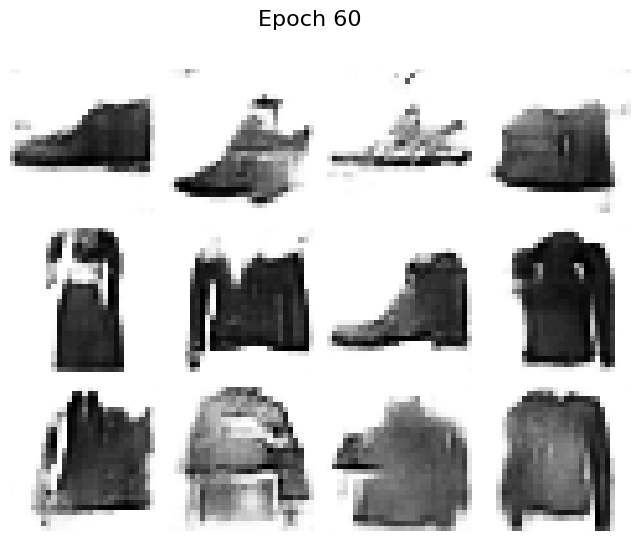

100%|██████████| 469/469 [00:28<00:00, 16.50it/s]


Epoch [61/100] | Loss D: -0.0036 | Loss G: -0.0174


100%|██████████| 469/469 [00:28<00:00, 16.41it/s]


Epoch [62/100] | Loss D: -0.0047 | Loss G: -0.0406


100%|██████████| 469/469 [00:28<00:00, 16.43it/s]


Epoch [63/100] | Loss D: -0.0038 | Loss G: -0.0407


100%|██████████| 469/469 [00:28<00:00, 16.48it/s]


Epoch [64/100] | Loss D: -0.0032 | Loss G: -0.0543


100%|██████████| 469/469 [00:29<00:00, 15.77it/s]


Epoch [65/100] | Loss D: -0.0041 | Loss G: -0.0629


100%|██████████| 469/469 [00:38<00:00, 12.30it/s]


Epoch [66/100] | Loss D: -0.0028 | Loss G: -0.0671


100%|██████████| 469/469 [00:39<00:00, 11.99it/s]


Epoch [67/100] | Loss D: -0.0033 | Loss G: -0.0830


100%|██████████| 469/469 [00:39<00:00, 11.96it/s]


Epoch [68/100] | Loss D: -0.0038 | Loss G: -0.0671


100%|██████████| 469/469 [00:39<00:00, 11.79it/s]


Epoch [69/100] | Loss D: -0.0038 | Loss G: -0.0845


100%|██████████| 469/469 [00:39<00:00, 11.97it/s]


Epoch [70/100] | Loss D: -0.0028 | Loss G: -0.0643


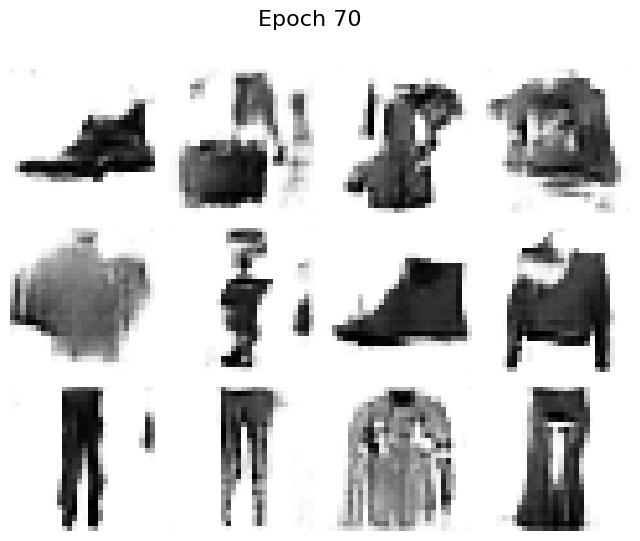

100%|██████████| 469/469 [00:39<00:00, 11.90it/s]


Epoch [71/100] | Loss D: -0.0037 | Loss G: -0.0879


100%|██████████| 469/469 [00:39<00:00, 11.98it/s]


Epoch [72/100] | Loss D: -0.0047 | Loss G: -0.0977


100%|██████████| 469/469 [00:40<00:00, 11.62it/s]


Epoch [73/100] | Loss D: -0.0039 | Loss G: -0.0717


100%|██████████| 469/469 [00:39<00:00, 11.74it/s]


Epoch [74/100] | Loss D: -0.0037 | Loss G: -0.0807


100%|██████████| 469/469 [00:38<00:00, 12.06it/s]


Epoch [75/100] | Loss D: -0.0040 | Loss G: -0.0784


100%|██████████| 469/469 [00:39<00:00, 11.80it/s]


Epoch [76/100] | Loss D: -0.0037 | Loss G: -0.0489


100%|██████████| 469/469 [00:40<00:00, 11.45it/s]


Epoch [77/100] | Loss D: -0.0037 | Loss G: -0.0265


100%|██████████| 469/469 [00:39<00:00, 11.83it/s]


Epoch [78/100] | Loss D: -0.0047 | Loss G: -0.0434


100%|██████████| 469/469 [00:39<00:00, 11.76it/s]


Epoch [79/100] | Loss D: -0.0034 | Loss G: -0.0229


100%|██████████| 469/469 [00:39<00:00, 11.73it/s]


Epoch [80/100] | Loss D: -0.0035 | Loss G: -0.0489


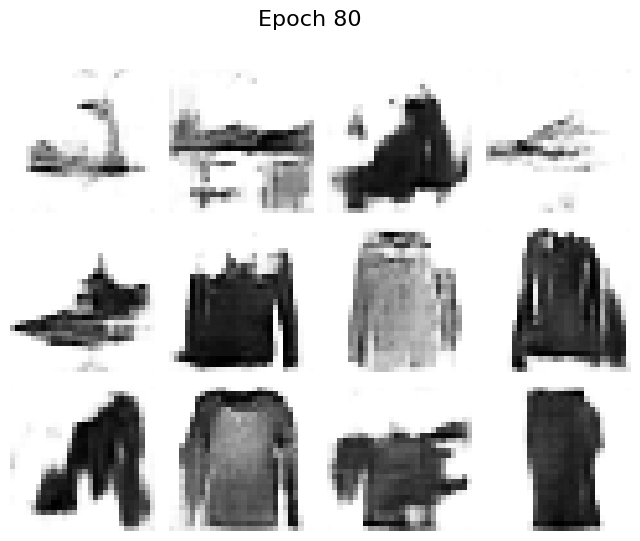

100%|██████████| 469/469 [00:38<00:00, 12.32it/s]


Epoch [81/100] | Loss D: -0.0051 | Loss G: -0.0503


100%|██████████| 469/469 [00:39<00:00, 11.93it/s]


Epoch [82/100] | Loss D: -0.0114 | Loss G: -0.0426


100%|██████████| 469/469 [00:39<00:00, 11.95it/s]


Epoch [83/100] | Loss D: -0.0244 | Loss G: -0.0372


100%|██████████| 469/469 [00:38<00:00, 12.08it/s]


Epoch [84/100] | Loss D: -0.0242 | Loss G: -0.0345


100%|██████████| 469/469 [00:40<00:00, 11.72it/s]


Epoch [85/100] | Loss D: -0.0226 | Loss G: -0.0355


100%|██████████| 469/469 [00:32<00:00, 14.42it/s]


Epoch [86/100] | Loss D: -0.0197 | Loss G: -0.0368


100%|██████████| 469/469 [00:41<00:00, 11.41it/s]


Epoch [87/100] | Loss D: -0.0159 | Loss G: -0.0397


100%|██████████| 469/469 [00:34<00:00, 13.74it/s]


Epoch [88/100] | Loss D: -0.0130 | Loss G: -0.0501


100%|██████████| 469/469 [00:39<00:00, 12.02it/s]


Epoch [89/100] | Loss D: -0.0065 | Loss G: -0.0593


100%|██████████| 469/469 [00:40<00:00, 11.54it/s]


Epoch [90/100] | Loss D: -0.0039 | Loss G: -0.0636


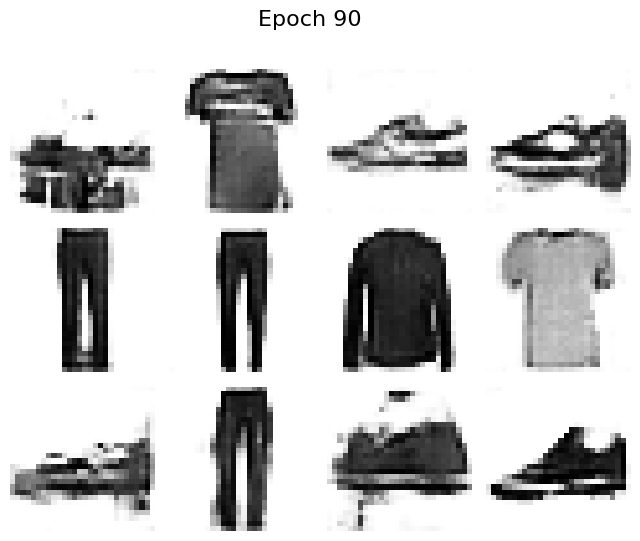

100%|██████████| 469/469 [00:29<00:00, 16.09it/s]


Epoch [91/100] | Loss D: -0.0027 | Loss G: -0.0488


100%|██████████| 469/469 [00:28<00:00, 16.18it/s]


Epoch [92/100] | Loss D: -0.0029 | Loss G: -0.0832


100%|██████████| 469/469 [00:29<00:00, 16.16it/s]


Epoch [93/100] | Loss D: -0.0038 | Loss G: -0.0623


100%|██████████| 469/469 [00:29<00:00, 16.17it/s]


Epoch [94/100] | Loss D: -0.0031 | Loss G: -0.0559


100%|██████████| 469/469 [00:28<00:00, 16.27it/s]


Epoch [95/100] | Loss D: -0.0031 | Loss G: -0.0279


100%|██████████| 469/469 [00:28<00:00, 16.20it/s]


Epoch [96/100] | Loss D: -0.0034 | Loss G: -0.0491


100%|██████████| 469/469 [00:28<00:00, 16.24it/s]


Epoch [97/100] | Loss D: -0.0031 | Loss G: -0.0262


100%|██████████| 469/469 [00:28<00:00, 16.27it/s]


Epoch [98/100] | Loss D: -0.0054 | Loss G: -0.0775


100%|██████████| 469/469 [00:28<00:00, 16.19it/s]


Epoch [99/100] | Loss D: -0.0044 | Loss G: -0.0753


100%|██████████| 469/469 [00:28<00:00, 16.18it/s]


Epoch [100/100] | Loss D: -0.0038 | Loss G: -0.0558


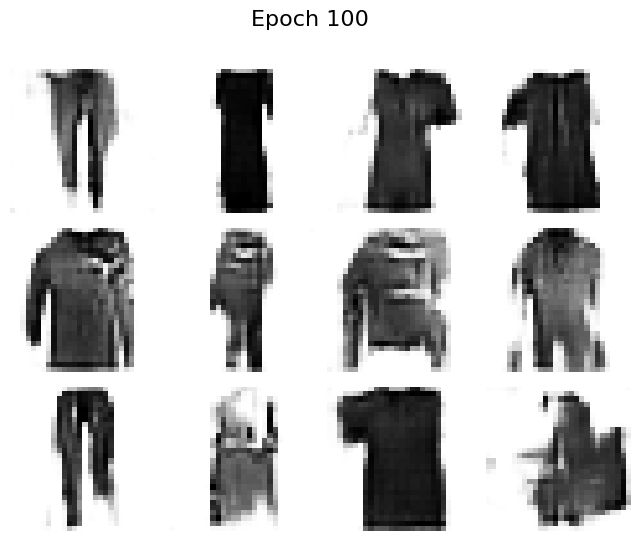

In [12]:
# Train the WGAN for a number of epochs in order to generate images.
# RUN this cell only if you want to train the model.
# If you want to generate images based on .pkl checkpoint, DON'T RUN this 
# training cell and the below cell that plots the losses.

# Main
seed = 42
tc.manual_seed(seed)
np.random.seed(seed)
device = 'cuda' if tc.cuda.is_available() else 'cpu'
print(f"Using --> {device}")

batch_size = 128
lr = 2e-4
betas = (0.5, 0.999)

# Load FashionMNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
train_set = FashionMNIST(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

data_shape = (1, 28, 28)
noise_dim = 100

# Create GENERATOR Object
gen = Generator(input_shape=data_shape, noise_shape=noise_dim).to(device)
gen.apply(weights_init)
opt_gen = RMSprop(params=gen.parameters(), lr=lr)

# Create DISCRIMINATOR Object
disc = Discriminator(input_shape=data_shape).to(device)
disc.apply(weights_init)
opt_disc = RMSprop(params=disc.parameters(), lr=lr)

# Initialize for the training
check_path = 'checkpoints/best_WGAN.pkl'
epochs = 100
n_samples = 12
sample_every = 10 
max_amp = 0.01  # Clipping range for discriminator parameters
d_iterations = 3 # Number of Discriminator trains per Batch

d_loss, g_loss = train_loop(gen, disc, opt_disc, opt_gen, train_loader, noise_dim,
                  n_samples, epochs, sample_every, max_amp, d_iterations, check_path, device)

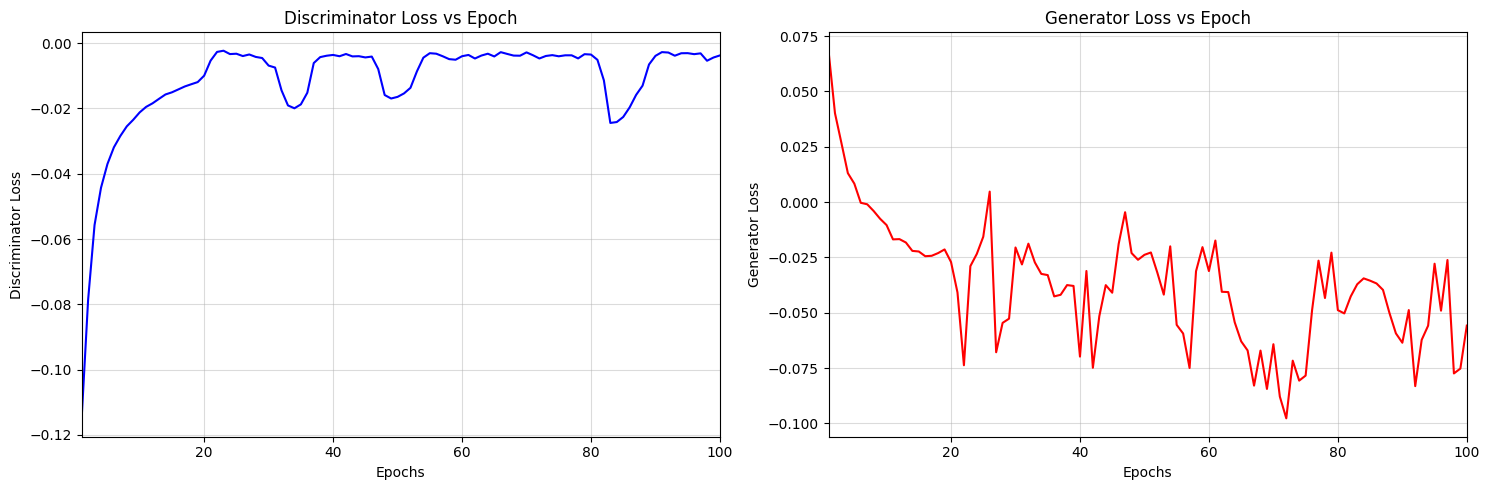

In [13]:
# Plot the DIscriminator and Generator Loss over Epochs

plot_loss(d_loss, g_loss, epochs)

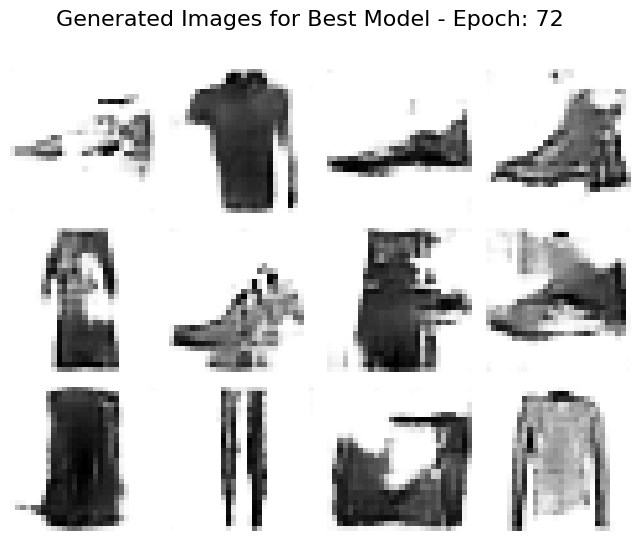

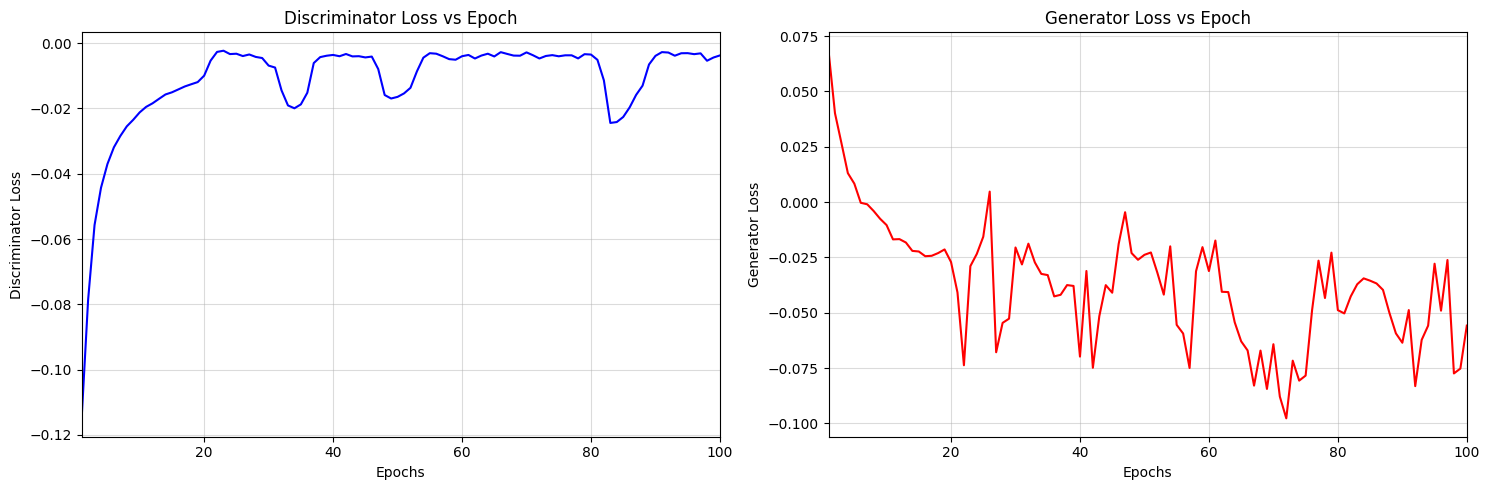

In [14]:
# LOAD AND GENERATE IMAGES based on the best Model of training
# IF YOU ONLY want to generate images and loss plots based on the 
# best trained model RUN all the cell EXCEPT the ABOVE TWO (training & plots) ↑

seed = 42
tc.manual_seed(seed)
np.random.seed(seed)
device = 'cuda' if tc.cuda.is_available() else 'cpu'

data_shape = (1, 28, 28)
noise_dim = 100

# Initialize for the training
check_path = 'checkpoints/best_WGAN.pkl'
n_samples = 12

load_and_generate(check_path, n_samples, data_shape, noise_dim, device)